In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import pathlib
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import layers

# Setup

In [2]:
train_dir = pathlib.Path("./train/")
test_dir = pathlib.Path("./test/")

In [3]:
image_count = len(list(pathlib.Path("").glob('*/*/*.jpg')))
print("All images: ", image_count)

All images:  1658


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 502 files belonging to 9 classes.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Analysis

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


Text(0.5, 1.0, 'Number of images per class in training set')

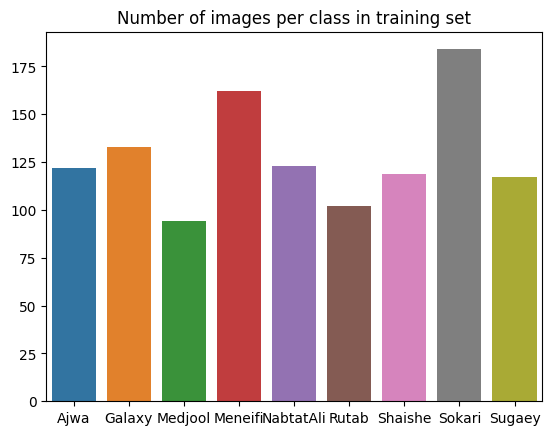

In [31]:
classesNambers = []
ourClasses = []
rootdir = './train/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in training set')

Text(0.5, 1.0, 'Number of images per class in test set')

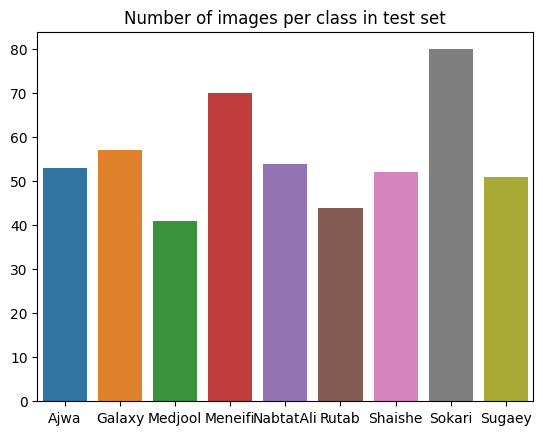

In [32]:
classesNambers = []
ourClasses = []
rootdir = './test/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in test set')

# Preprocessing

Normalize the data

In [9]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixel values are now in `[0,1]`.

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Architecture

In [10]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = (img_height, img_width, 3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(101, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")

# Training

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "FeatureExtractionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 outputLayer (Dense)         (None, 101)               129381    
                                                                 
 activationLayer (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 12

In [13]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


C:\Users\bassa\anaconda3\envs\DataScience\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


37/37 [==============================] - 53s 1s/step - loss: 1.8422 - accuracy: 0.5251 - val_loss: 0.9517 - val_accuracy: 0.8207
Epoch 2/20
37/37 [==============================] - 39s 1s/step - loss: 0.7171 - accuracy: 0.8841 - val_loss: 0.5752 - val_accuracy: 0.8924
Epoch 3/20
37/37 [==============================] - 42s 1s/step - loss: 0.4705 - accuracy: 0.9265 - val_loss: 0.4511 - val_accuracy: 0.9124
Epoch 4/20
37/37 [==============================] - 46s 1s/step - loss: 0.3670 - accuracy: 0.9377 - val_loss: 0.3689 - val_accuracy: 0.9223
Epoch 5/20
37/37 [==============================] - 42s 1s/step - loss: 0.3032 - accuracy: 0.9498 - val_loss: 0.3292 - val_accuracy: 0.9263
Epoch 6/20
37/37 [==============================] - 45s 1s/step - loss: 0.2645 - accuracy: 0.9533 - val_loss: 0.2871 - val_accuracy: 0.9363
Epoch 7/20
37/37 [==============================] - 45s 1s/step - loss: 0.2313 - accuracy: 0.9593 - val_loss: 0.2659 - val_accuracy: 0.9442
Epoch 8/20
37/37 [=============

# Evaluation

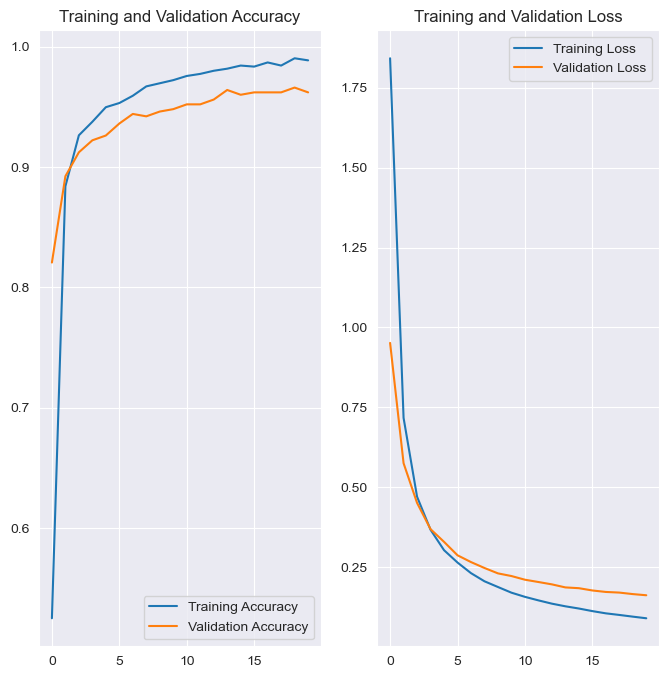

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
predicted = []
true_labels = []
dirs = list(test_dir.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 67ms/step


Classification Report

In [19]:
flat_predicted = [item for sublist in predicted for item in sublist]

print(classification_report(true_labels, flat_predicted, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Ajwa     1.0000    1.0000    1.0000        53
      Galaxy     0.9821    0.9649    0.9735        57
     Medjool     1.0000    0.9512    0.9750        41
     Meneifi     0.8800    0.9429    0.9103        70
   NabtatAli     1.0000    0.9630    0.9811        54
       Rutab     0.9556    0.9773    0.9663        44
     Shaishe     0.9792    0.9038    0.9400        52
      Sokari     0.9615    0.9375    0.9494        80
      Sugaey     0.8750    0.9608    0.9159        51

    accuracy                         0.9542       502
   macro avg     0.9593    0.9557    0.9568       502
weighted avg     0.9564    0.9542    0.9546       502



Confusion Matrix

<AxesSubplot:>

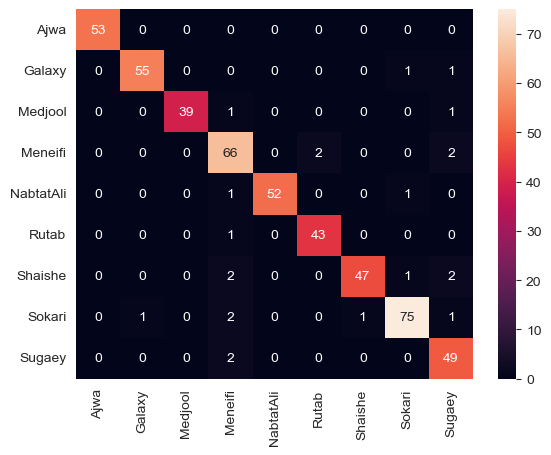

In [18]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)